# Solution

Anvitha Chegu Ashokkumar

# Answer to Questions given in the challenge

**Update to Answer5 based on the query -** <br>
Yes, you are right. It would only reduce the size significantly when there is a significant overlap and they merge as we are using RLE encoding where we only store the count of consecutive 1s and their starting indices, instead of storing count of consecutive 0s and consecutive 1s. If we were using the second way of encoding, we won't have to store consecutive 0s twice. But in our approach, the memory saving would not be significant and that too in a rare case. Additionally, it would add complexity in determining the overlap percentage and detecting cancer as the blobs would be merged. 

So, my initial suggestion that storing the images together would reduce the size was incorrect for the encoding methodology I have used. That was a mistake from my side in the explanation.


1. For efficient storage and processing of the micro-organism image, I converted it to a Run Length Encoding (RLE) representation. In RLE, the binary image is represented by the starting index and count of consecutive 1s, which reduces storage space significantly, as large sequences of consecutive 1s (blobs) can be stored using just two integers each. To handle the large image size during RLE conversion, I split the image into 20 chunks of shape (5000, 100000), where each chunk corresponds to 5000 rows. This chunking approach allowed me to fit the large image in memory during the encoding process. The same RLE representation was used for the dye image as well, since RLE stores only the 1s, making it efficient even for sparse images. Both the RLE data structures were stored in JSON files for later retrieval.

2. To generate fake simulated images, I utilized Bezier curves, which can create smooth, connected curves of arbitrary shapes. For the microorganism blob, I constructed a sufficiently large Bezier curve that occupied over 25% of the image area to meet the given requirement. For the dye image, I created multiple smaller Bezier curves. Both the microorganism curve and the dye curves were then filled as polygons using the skimage library, converting them into blobs. The initial generation of the fake simulated images was done at a smaller 1000 x 1000 pixel size, after which they were upscaled to the required 100000 x 100000 pixel dimensions using the OpenCV library's resize method.

3. The function **has_cancer** operates on the run-length encoded (RLE) representations of the 2 images, which are processed in chunks. It calculates the percentage of the blob area covered by the dye across all chunks. The calculated percentages are then aggregated, and the final result is printed based on a threshold of 10%. If the dye covers more than 10% of the blob area, the micro-organism is classified as having cancer; otherwise, it is classified as not having cancer.

4. The implementation can be optimized for faster performance by processing the image chunks in parallel using multiple threads. Once all threads complete their respective chunk computations, the results can be aggregated to produce the final output. Also, decreasing the chunk size would result in a larger number of chunks, enabling better utilization of multiple threads, but it may also lead to a marginal increase in storage requirements. Given the time constraint of 2 hours, I could only implement the single-threaded version of the algorithm. 

5. Since I worked directly with full-size images (100000 x 100000 pixels) instead of scaled-down versions, the runtime of my code for generating sample images and detecting cancer is around 130 seconds, with the detection part consuming around 70 seconds. Considering the worst-case scenario where the sequence of 1s is only one element long, i.e., alternating 1s and 0s are present in the image, representing the largest index for the last 1, depending on our chunk size of 5000 rows in our implementation would require 29 bits, as the maximum value is 500 million. If we allocate an additional 8 bits for storing the count (which would be 1 in this case, as the 1s alternate with 0s), the total number of bits required per occurrence of 1 would be 37 bits. With a total of (100000 x 100000)/2 = 5 billion occurrences of 1s, the worst-case storage requirement would be approximately 23 GBs approximately, which is higher than 1.25 GBs required for storing the image directly. 

    But in real world scenarios and given a typical image, a blob would significantly reduce the image size with my implementation. For example, a generated typical image takes about 3 MB to store which approx 400x smaller than the actual image. An alternative compression technique would be to combine both images and then perform RLE encoding, which could significantly reduce the storage space required.

6. The tools that I used for the challenge were Stackoverflow, ChatGPT, Claude 3 and Perplexity.ai for checking different techinques to generate random blobs in images. Further, I used OpenCV to do any kind of image processing like scaling. Jupyter notebook along with VSCode was utilized as the coding environment for running the experiments. LLM platforms mentioned above were also helpful in understanding and implementing Run Length Encoding which would be suitable for the given use case. Skiimage libray was used for filling up polygons and matplotlib for plotting images.


In [1]:
import json
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from scipy.special import binom
import skimage.draw as draw
import cv2

# Util functions

## Functions for generating random test images of micro organism and dye of size 100000*100000

Utilized Bezier curve for generating the images of micro organism blob and dye spread. 

Microorganism blob is a single shape in the image, whereas dye can be multiple shapes.

Reference - [Stackoverflow](https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib)

In [2]:
bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points [a], create a curve through
    those points. 
    rad = is a number between 0 and 1 to steer the distance of
          control points.
    edgy = controls the smoothness of the curve, with edgy=0 being the smoothest.
    """
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

In [3]:
def augment_img_with_shapes(image, scale, c, rad, edgy, shape):
    a = get_random_points(n=7, scale=scale) + c
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    rr, cc = draw.polygon(x, y, shape=shape)
    image[rr, cc] = 1

    return image

### Function for generating an image with a blob of the micro organism.

Steps - 
1. Generate the bezier curve for the migroorganism blob using a set of 2d coordinates.
2. Fill the curve as a polygon.

In [4]:
def get_random_microorganism_image():
    """
    Returns an image with a randomly generated blob representing micro organism body.
    draw.polygon is used to form a filled polygon from the bezier curve recieved as 2d coordinates.

    The image is generated first is of size 1000*1000 which is then scaled up to 100000*100000 using cv2. This helps in efficiently generating testing samples.
    """
    rad = 0.2
    edgy = 0.05
    shape = (1000, 1000)
    image = np.zeros(shape, dtype=np.uint8)
    c = [0,0]

    image = augment_img_with_shapes(image, shape[0], c, rad, edgy, shape)
    image = cv2.resize(image, dsize=(100000, 100000), interpolation=cv2.INTER_LINEAR)

    return image

### Function for generating an image with several small blobs representing dye spread using Bezier curve.

Steps - 
1. Choose a random number of blobs to generate between 3 and 10.
2. Generate a set of random points for each one of them.
3. Generate the bezier curve for each set of random points which will represent the dye spread.
4. Fill each one of them as polygons.

In [5]:
def get_dye_image(scale=100):
    """
    Returns an image with randomly generated blobs representing dye spread.
    The method randomly generates between 3 to 10 datapoints that serve as center for the blobs to be generated.
    draw.polygon is used to form a filled polygon from the bezier curve recieved as 2d coordinates.

    The image is generated first is of size 1000*1000 which is then scaled up to 100000*100000 using cv2. This helps in efficiently generating testing samples.

    scale = Scale parameter controls the size of the blob which will help for testing with different percentage of dye spread in the micro organism.
    """
    rad = 0.2
    edgy = 0.05
    shape = (1000, 1000)
    image = np.zeros((1000, 1000), dtype=np.uint8)
    num_elements = np.random.randint(3, 10)
    cs = np.random.rand(num_elements, 2) * 1000
    for c in cs:
        image = augment_img_with_shapes(image, scale, c, rad, edgy, shape)

    image = cv2.resize(image, dsize=(100000, 100000), interpolation=cv2.INTER_LINEAR)
    return image


### Fucntions for encoding and decoding images using Run Length Encoding. 
I use a variation of RLE where we only store consecutive 1s as count and their starting index, removing 0s completely. 

This method also helps in storing sparse matrices efficiently.

In [6]:
def rle_encode_image(mask):
    '''
    mask: image as binary mask --> 1 - mask (blob), 0 - background
    
    Returns encoded image 
    '''
    pxls = mask.flatten()
    pxls = np.concatenate([[0], pxls, [0]])
    seqs = np.where(pxls[1:] != pxls[:-1])[0] + 1
    seqs[1::2] -= seqs[::2]
    return ' '.join(str(seq) for seq in seqs)


In [7]:
def decode_rle_image(rle_image, h, w):
    '''
    rle_image: rle encodded image as formatted string (start index, count of consecutive 1s following the index)
    h: height of the mask 
    w: width of the mask
    returns decode image
    '''
    rle_image = np.array(rle_image.split(' ')).reshape(-1, 2)
    img = np.zeros((h*w))

    for i in rle_image:
        img[int(i[0]):int(i[0])+int(i[1])] = 1

    return img.reshape(h, w)

## Splitting images into chunks for efficient processing

Due to resource constraints and the need for faster processing, I am splitting the images down into chunks of IMG_CHNK_SIZE * 100000. Selecting a chunk size of 5000, the image is divided into 20 chunks, each comprising 5000 rows and 100000 columns. This approach helps in efficiently processing the images for cancer detection in the parasite. Although, it slightly increases the storage size, it significantly enhances the processing speed and also reduces the RAM requirements. Moreover, this approach can further help in parallelization later, as separate chunks can be processed in parallel using multiple threads.

In [8]:
IMG_CHNK_SIZE = 5000

### Funciton for RLE encoding image chunk by chunk.

In [9]:
def chunk_and_rle_encode(img):
    """
    image: input image of shape 100000*100000 
    
    Splits input image into into chunks of size IMG_CHNK_SIZE*100000 
    Each chunk is encoded iteratively using RLE.
    
    Returns a list of RLE encoded chunks.
    """
    chunked_rle_encodings = []
    for i in tqdm(range(0, 100000, IMG_CHNK_SIZE)):
        chunked_rle_encodings.append(rle_encode_image(img[i:i+IMG_CHNK_SIZE]))
    return chunked_rle_encodings

### Masking
Takes to corresponding chunks from blob image and dye image and applies the first chunk as mask for the second image. This ensures that any dye which is outside the blob is not considere.
Then it calculates the percentage of area in the chunk covered by the blob and percentage of area in the chunk covered by the newly masked dye and returns these 2 values.

Both the the chunks correspond to the same number of rows in the images.

In [10]:
def mask_chunk(img_mask_chunk, dye_mask_chunk):
    """
    img_mask_chunk: image chunk of size IMG_CHNK_SIZE*100000 for microorganism image
    dye_mask_chunk: dye chunk of size IMG_CHNK_SIZE*100000 for dye image (corresponds to the same region)
    
    The image chunks correspond to the same row indices in their respective images.

    Compares the 2 input image chunks by applying the blob chunk as mask on the dye chunk.
    This eliminates any leaked dyes outside the microorganism blob.
    
    Calculates the percentage of area covered by blob in its chunk
    Calculates the percentage of area covered by dye in its chunk after masking.

    returns the above 2 percentatges.
    """
    msk1, msk2 = img_mask_chunk, dye_mask_chunk
    masked_msk2 = np.where(msk1 == 1, msk2, 0)
    per_msk1 = np.count_nonzero(msk1 == 1) / msk1.size * 100
    per_msk2 = np.count_nonzero(masked_msk2 == 1) / masked_msk2.size * 100
    return per_msk1, per_msk2

## Function for checking if parasite has cancer or not.

Takes the 2 rle encoded images as input.

To process the images, we iterate over the lists together, taking encodings for the same row indices chunks for both the images and decode them. 

After decoding the chunk encodings, we utilize the mask_chunk method to obtain the percentages of areas covered by the blob in the chunk and the dye in the chunk that falls within the blob area. 

Once the percentages have been calculated for all the chunks, we sum the percentages for both images and normalize the result by the number of chunks. 

The first percentage represents the proportion of the image area covered by the blob. 

The second percentage, divided by the first one, gives us the percentage of the area covered by the dye within the blob region.

In [17]:
def has_cancer(rle_encoded_img, rle_encoded_dye):
    """
    rle_encoded_img: rle encoded chunks of microorganism image
    rle_encoded_dye: rle encoded chunks of dye image


    Prints the results and checks if dye covered area of blob is greater than threshold of 10 to check whether microorganism has cancer or not.
    """
    prcntg_list_1 = []
    prcntg_list_2 = []
    for i, (rle_image, rle_dye) in enumerate(tqdm(zip(rle_encoded_img, rle_encoded_dye), total=len(rle_encoded_img))):
        if rle_image != '':
            img_chunk_msk = decode_rle_image(rle_image, IMG_CHNK_SIZE, 100000)
            dye_chunk_msk = np.zeros((IMG_CHNK_SIZE, 100000))
            if rle_dye != '':
                dye_chunk_msk = decode_rle_image(rle_dye, IMG_CHNK_SIZE, 100000)

            prcntg_msk_1, prcntg_msk_2 = mask_chunk(img_chunk_msk, dye_chunk_msk)
            prcntg_list_1.append(prcntg_msk_1)
            prcntg_list_2.append(prcntg_msk_2)
        else:
            prcntg_list_1.append(0)
            prcntg_list_2.append(0)

        # decoded_image[start:end] = mask
    blob_prcntg = sum(prcntg_list_1)/len(rle_encoded_img)
    dye_prctng = sum(prcntg_list_2)/len(rle_encoded_img)
    cancer_prcntg = dye_prctng/blob_prcntg*100

    print(f"Area in the image covered by blob: {blob_prcntg}%")
    print(f"Area of the blob where dye has spread: {cancer_prcntg}%")
    print(f"Parasite has cancer? {cancer_prcntg > 10}")

## Testing on simulated images

Display size of images are 10000 * 10000. 

All processing of image is done on full size of 100000 * 100000.

In [18]:
def process_parasite_file(img_id):
    data = json.load(open(f'rle_img_{img_id}.json'))
    rle_encodings_img, rle_encodings_dye = data['blob'], data['dye']
    has_cancer(rle_encodings_img, rle_encodings_dye)

### Test 1 - No cancer in parasite

Shape of blob img: (100000, 100000)
Shape of dye img: (100000, 100000)


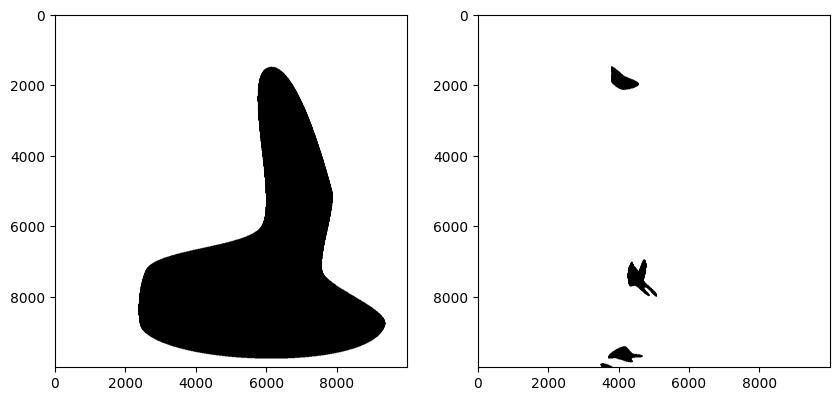

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
img_id = 1

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

img = get_random_microorganism_image()
axes[0].imshow(cv2.bitwise_not(cv2.resize(img, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

img_dye = get_dye_image()
axes[1].imshow(cv2.bitwise_not(cv2.resize(img_dye, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

print(f"Shape of blob img: {img.shape}")
print(f"Shape of dye img: {img_dye.shape}")
plt.show()

print()
rle_encodings_img = chunk_and_rle_encode(img)
rle_encodings_dye = chunk_and_rle_encode(img_dye)

data = {
    'blob': rle_encodings_img,
    'dye': rle_encodings_dye
}
json.dump(data, open(f'rle_img_{img_id}.json', 'w'))

Loading stored encoded images from disk for detecting cancer.

In [20]:
process_parasite_file(img_id)

  0%|          | 0/20 [00:00<?, ?it/s]

Area in the image covered by blob: 25.811784010000004%
Area of the blob where dye has spread: 1.7762314291115127%
Parasite has cancer? False


### Test case 2 - Cancer in parasite.

Note: I try to generate large enough dye blobs so that they cover more than 10% of the microogranism and hence, cancer is detected for this case. But it can be the case in a rare scenario that the covered region randomly generated is less than 10%

Shape of blob img: (100000, 100000)
Shape of dye img: (100000, 100000)


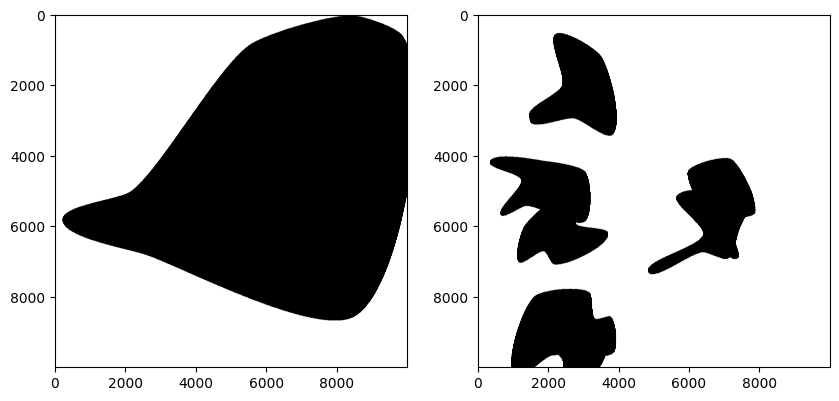

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
img_id = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

img = get_random_microorganism_image()
axes[0].imshow(cv2.bitwise_not(cv2.resize(img, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

# increasing scale to generate bigger dye spreads for positive cancer case
img_dye = get_dye_image(scale=400)
axes[1].imshow(cv2.bitwise_not(cv2.resize(img_dye, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

print(f"Shape of blob img: {img.shape}")
print(f"Shape of dye img: {img_dye.shape}")
plt.show()

print()
rle_encodings_img = chunk_and_rle_encode(img)
rle_encodings_dye = chunk_and_rle_encode(img_dye)

data = {
    'blob': rle_encodings_img,
    'dye': rle_encodings_dye
}
json.dump(data, open(f'rle_img_{img_id}.json', 'w'))

In [22]:
process_parasite_file(img_id)

  0%|          | 0/20 [00:00<?, ?it/s]

Area in the image covered by blob: 51.805642920000004%
Area of the blob where dye has spread: 16.251831953907924%
Parasite has cancer? True
